# Flower Images Classification

# Data Description

The dataset was taken from: https://www.kaggle.com/datasets/jonathanflorez/extended-flowers-recognition

The dataset contains about 8,100 labeled images of 10 different flower species. There are 10 flower classes with somewhere around ~600-900 images each: aster, daffodil, dahlia, daisy, dandelion, iris, orchid, rose, sunflower, tulip.

Let's try to build a computer vision model that can classify flowers.

# Importing necessary libraries & loading data

In [1]:
import os
from tqdm.autonotebook import tqdm, trange
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import copy
from __future__ import print_function, division
import time
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision.models import resnet34
import random

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
!pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d jonathanflorez/extended-flowers-recognition

 98% 729M/743M [00:06<00:00, 118MB/s]
100% 743M/743M [00:06<00:00, 122MB/s]


In [7]:
!unzip extended-flowers-recognition.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: flowers/dandelion/17077940105_d2cd7b9ec4_n.jpg  
  inflating: flowers/dandelion/17080000869_a80e767f4a_m.jpg  
  inflating: flowers/dandelion/17095758258_a33642946f_n.jpg  
  inflating: flowers/dandelion/17122969189_0ec37cb6c9.jpg  
  inflating: flowers/dandelion/17135145776_4c2ec21b05_m.jpg  
  inflating: flowers/dandelion/17146644679_11aff3045c.jpg  
  inflating: flowers/dandelion/17147436650_c94ae24004_n.jpg  
  inflating: flowers/dandelion/17161833794_e1d92259d2_m.jpg  
  inflating: flowers/dandelion/17175932454_c052e205c1_n.jpg  
  inflating: flowers/dandelion/17189437699_a9171b6ae3.jpg  
  inflating: flowers/dandelion/17220096449_0e535989f0_n.jpg  
  inflating: flowers/dandelion/17243540220_65b98eb926_n.jpg  
  inflating: flowers/dandelion/17244252705_328e0bcda6.jpg  
  inflating: flowers/dandelion/17276354745_2e312a72b5_n.jpg  
  inflating: flowers/dandelion/17280886635_e384d91300_n.jpg  
  inflatin

# Data Preprocessing

In [8]:
data_dir = './flowers'
data_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(244),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder(data_dir, transform=data_transform)

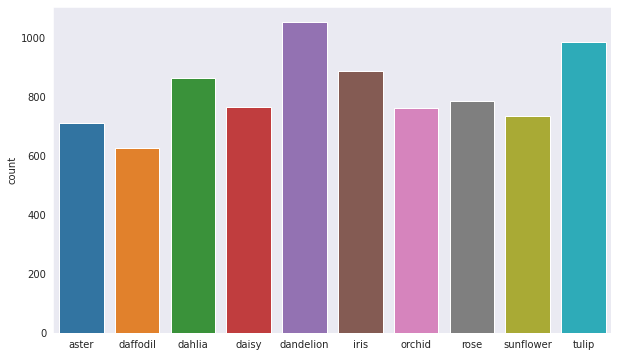

In [ ]:
# checking for class imbalance
plt.figure(figsize=(10, 6))
labels = dataset.classes
l = [labels[i[1]] for i in dataset]
sns.set_style('dark')
sns.countplot(x=l)
plt.show()
del l

As we can see, there is no significant class imbalance.

In [9]:
# splitting data into train and validation sets
dataset_size = len(dataset)
test_size = 0.25
batch_size = 32
indexes = list(range(dataset_size))
np.random.seed(42)
np.random.shuffle(indexes)
split = int(np.floor(dataset_size * test_size))

train_indexes, val_indexes = indexes[split:], indexes[:split]
train_sampler = SubsetRandomSampler(train_indexes)
val_sampler = SubsetRandomSampler(val_indexes)

train_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(244),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_loader = DataLoader(datasets.ImageFolder(data_dir, transform=train_transform), batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
data_loaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_indexes), 'val': len(val_indexes)}

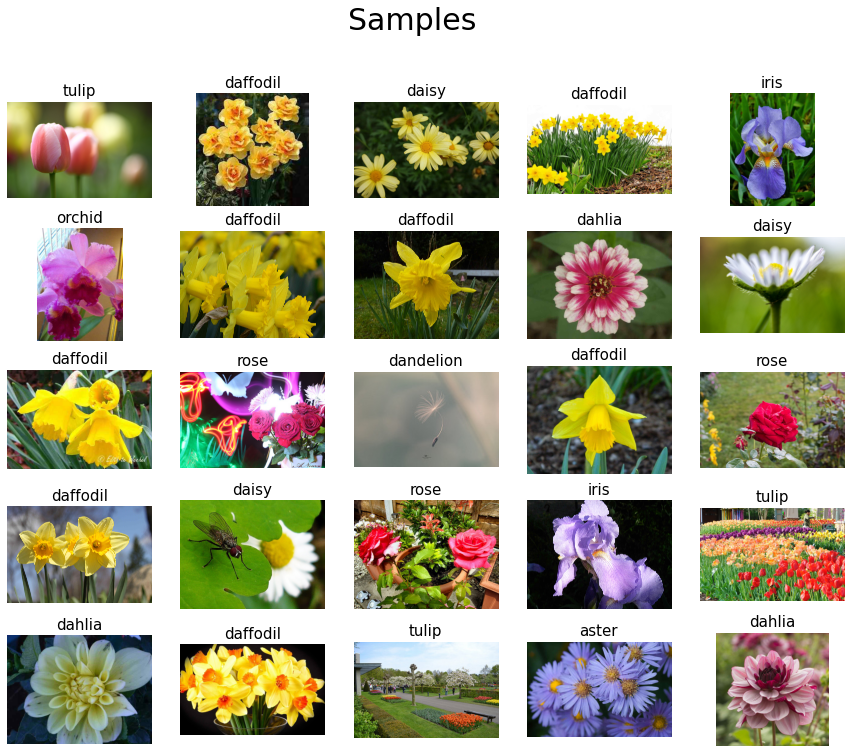

In [10]:
# let's take a look at few samples of our dataset
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,12))
    i = 0
    for row in range(5):
         for col in range(5):
                img = mpimg.imread(samples[i][0][0])
                ax[row][col].imshow(img)
                ax[row][col].axis('off')
                ax[row][col].set_title(samples[i][1], fontsize=15)
                i+=1
  

rand_samples = [] 
for _ in range(25): 
    classes = random.choice(dataset.classes)
    rand_samples.append([random.sample([os.path.join(data_dir+'/'+classes, filename) for filename in os.listdir(data_dir+'/'+classes)], 1), classes]) 
rand_samples[0]
plot_samples(rand_samples)
plt.suptitle('Samples', fontsize=30)
plt.show()

# Transfer Learning

In [11]:
model = resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# freezing model parameters and changing the last layer
for parameter in model.parameters():
    parameter.requires_grad = False
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
model.load_state_dict(torch.load('Flower_classifier.pth'))

<All keys matched successfully>

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_network(model, criterion, optimizer, scheduler, n_epochs):
    start = time.time()
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    best_accuracy = 0.0
    best_weights = copy.deepcopy(model.state_dict())
    progress_bar = trange(n_epochs, desc='Epoch:')
    for epoch in progress_bar:
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in tqdm(data_loaders[mode], leave=False, desc=f'{mode} iter:'):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                if mode == 'train':
                    optimizer.zero_grad()
                    outputs = model(inputs)
                elif mode == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))
            if mode == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[mode]
            epoch_acc = running_corrects / dataset_sizes[mode]
            losses[mode].append(epoch_loss)
            accuracies[mode].append(epoch_acc)
            progress_bar.set_description('{} Loss: {:.3f} Accuracy {:.3f}'.format(mode, epoch_loss, epoch_acc))
            if mode == 'val' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_weights)
    training_time = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(training_time // 60, training_time % 60))
    print('Best validation accuracy: {:.3f}'.format(best_accuracy))
    return model, losses

In [ ]:
model, losses = train_network(model, loss_func, optimizer, scheduler, n_epochs=12)

Epoch::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

train iter::   0%|          | 0/192 [00:00<?, ?it/s]

val iter::   0%|          | 0/64 [00:00<?, ?it/s]

Training complete in 64m 28s
Best validation accuracy: 0.914


# Visualizing model performance

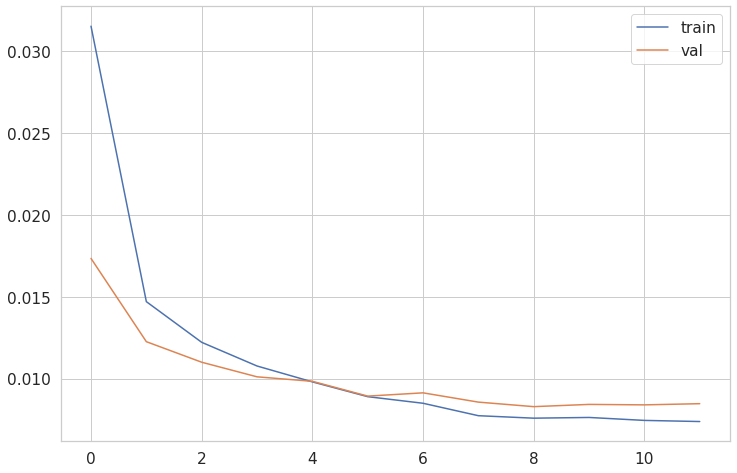

In [ ]:
sns.set(style='whitegrid', font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label='train')
plt.plot(losses['val'], label='val')
plt.legend()
plt.show()

In [18]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(7, 7))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

class_names = dataset.classes

def visualize_preds(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, real: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

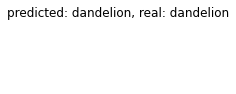

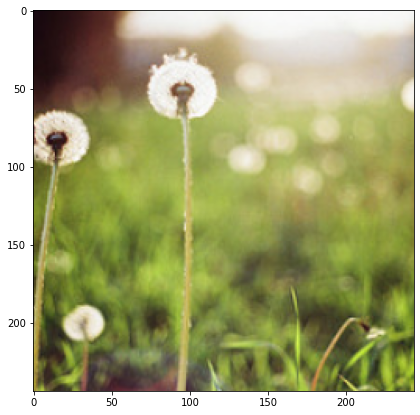

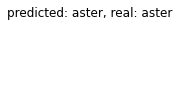

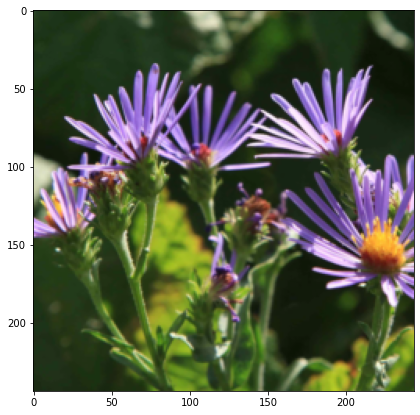

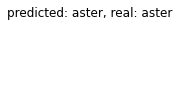

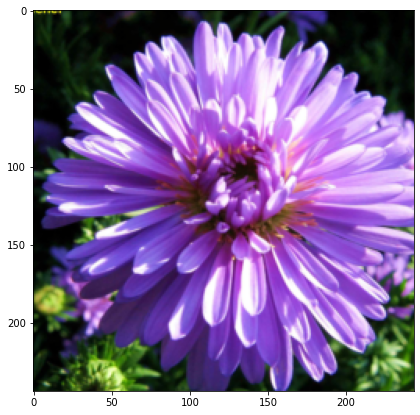

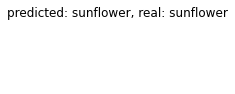

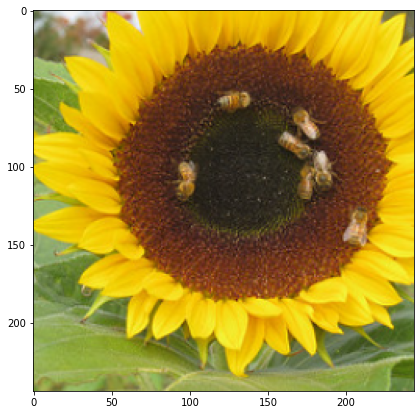

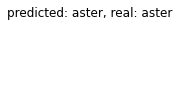

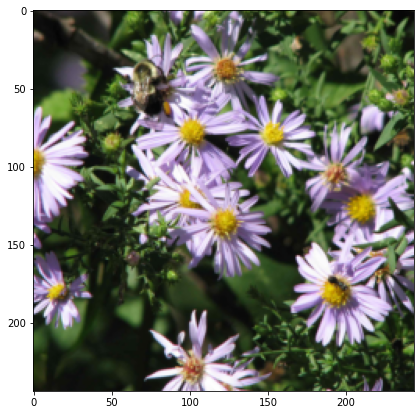

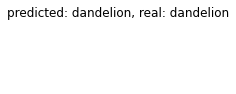

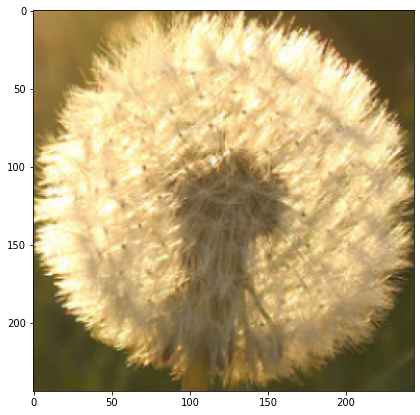

In [20]:
visualize_preds(model)

In [ ]:
#torch.save(model.state_dict(), 'Flower_classifier.pth')